# Soils Revealed explore section mockup

In this notebook we create the different outputs for the `Explore Section` of the [prototype](https://invis.io/YPSLZAR29UD).

## Explore Section
- ### [Soil Layers](#layers)
    - **[SOC stock](#SOC_stock_layer)**
    - **[SOC concentration](#SOC_concentration_layer)**
    - **[Soil carbon debt of 12,000 years of human land use](#SOC_debt_layer)**
- ### [Areas to Watch](#areas)
- ### [Analysis](#analysis)
    - #### **[SOC Profile](#SOC_profile)**
        - #### [SOC concentration](#SOC_concentration_profile)
            - **[Argentina](#SOC_concentration_profile_argentina)**
            - **[Entre Ríos](#SOC_concentration_profile_rios)**
            - **[Compare](#SOC_concentration_profile_compare)**
        - #### [SOC stock](#SOC_stock_profile)
            - **[Argentina](#SOC_stock_profile_argentina)**
            - **[Entre Ríos](#SOC_stock_profile_rios)**
            - **[Compare](#SOC_stock_profile_compare)**
    - #### **[SOC Time series](#SOC_time_series)**
        - #### [SOC concentration](#SOC_concentration_time)
            - **[Argentina](#SOC_concentration_time_argentina)**
            - **[Entre Ríos](#SOC_concentration_time_rios)**
        - #### [SOC stock](#SOC_stock_time)
            - **[Argentina](#SOC_concentration_time_argentina)**
            - **[Entre Ríos](#SOC_concentration_time_rios)**
    - #### **[SOC Change](#SOC_change)**
        - #### [SOC concentration](#SOC_concentration_change)
            - **[Argentina](#SOC_concentration_change_argentina)**
            - **[Entre Ríos](#SOC_concentration_change_rios)**
            - **[Compare](#SOC_concentration_change_compare)**
        - #### [SOC stock](#SOC_stock_change)
            - **[Argentina](#SOC_stock_change_argentina)**
            - **[Entre Ríos](#SOC_stock_change_rios)**
            - **[Compare](#SOC_stock_change_compare)**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import json
import folium
import ee

Initialize the Earth Engine client.

In [2]:
ee.Initialize()

In [3]:
def tile_url(image, viz_params=None):
    """Create a target url for tiles for an image.
    """
    if viz_params:
        d = image.getMapId(viz_params)
    else:
        d = image.getMapId()
    base_url = 'https://earthengine.googleapis.com'
    url = (base_url + '/map/' + d['mapid'] + '/{z}/{x}/{y}?token=' + d['token'])
    return url

In [4]:
def display_layes(layer_name, years, depths, bands, file_name, min = 0, max=70, factor=None):    
    step_palette = "#E3D0B4, #D8BC94, #DCBA87, #AC9067, #8D724A, #786451, #604D35, #4C3B29, #37312B" 
    change_palette = "#B30200, #E34A33, #FC8D59, #FDCC8A, #FFFFCC, #A1DAB4, #31B3BD, #1C9099, #066C59"
    
    bands_dic = dict(zip(bands, depths))
    
    collection = ee.ImageCollection(f'users/iker/SOC_maps/{file_name}')
    first_image = collection.first()
    polygon = first_image.geometry()
    location = polygon.centroid().getInfo().get('coordinates')[::-1]
    bbox = polygon.bounds().getInfo().get('coordinates')
    bounds = [bbox[0][0][::-1], bbox[0][2][::-1]]
    
    m = folium.Map(location=location)
    m.fit_bounds(bounds)
    
    for depth in depths:
        for band in bands:
            images = []
            for year in years:
                image = ee.Image(collection.filterDate(f'{year}-01-01', f'{year}-12-31').first()).select(band)
                if factor:
                    image = image.divide(factor)
                tile_rgb = tile_url(image, {'min': min, 'max': max, 'palette': step_palette})
                folium.TileLayer(tiles=tile_rgb, attr="Live EE tiles", overlay=True, name=f'{layer_name} {bands_dic[band]} cm {year} year').add_to(m)
                images.append(image)
        
            change = images[1].select(band).subtract(images[0].select(band))
            tile_rgb = tile_url(change, {'min': -int(max/3), 'max': int(max/3), 'palette': change_palette})
            folium.TileLayer(tiles=tile_rgb, attr="Live EE tiles", overlay=True, name=f'{layer_name} change {bands_dic[band]} cm {years[0]} - {years[1]} years').add_to(m)
            
    m.add_child(folium.LayerControl())
    
    return m  

In [5]:
def ee_stats(image,coords):
    # Combine the mean and standard deviation reducers.
    reducers = ee.Reducer.minMax().combine(reducer2= ee.Reducer.mean(), sharedInputs = True)\
                                  .combine(reducer2= ee.Reducer.sum(), sharedInputs = True)

    statReducer = {
        'collection': ee.FeatureCollection(ee.Geometry.Polygon(coords)),#ee.FeatureCollection(features),
        'reducer': reducers}

    # Use the combined reducer to get the mean and SD of the image.
    stats = image.reduceRegions(**statReducer).toList(10000).getInfo()

    return stats[0].get('properties')

In [6]:
def ee_fixHist(image, polygon, params):
    
    coords = extract_poly_coords(polygon)
    
    regReducer = {
        'collection': ee.FeatureCollection(ee.Geometry.Polygon(coords)),
        'reducer': ee.Reducer.fixedHistogram(min=params['min'], max=params['max'], steps=params['steps'])
    }

    return image.reduceRegions(**regReducer).toList(10000).getInfo() 

In [7]:
def extract_poly_coords(geom):
    if geom.type == 'Polygon':
         geom =  geom 
    elif geom.type == 'MultiPolygon':
        # take biggest Polygon from the MultiPolygon
        geom = max(geom, key=lambda a: a.area)
    else:
        raise ValueError('Unhandled geometry type: ' + repr(geom.type))
        
    coords = np.asarray(geom.exterior.coords).tolist()
    return coords

In [8]:
def tot_gain_loss(image, df):
    tot = []
    gain = []
    loss = []
    
    mask_gt = image.gte(0)
    mask_lt = image.lte(0)
    
    positive = image.updateMask(mask_gt)
    negative = image.updateMask(mask_lt)

    for i in range(len(df)):
        if i == 0:
            polygon = df['geometry'].iloc[i][218:219]
        else:
            polygon = df['geometry'].iloc[i]
        
        stats = ee_stats(image, extract_poly_coords(polygon))
        tot.append(stats.get('sum'))
    
        stats = ee_stats(positive, extract_poly_coords(polygon))
        gain.append(stats.get('sum'))
    
        stats = ee_stats(negative, extract_poly_coords(polygon))
        loss.append(stats.get('sum'))
    
        print(df['NAME_1'].iloc[i])
        
    return tot, gain, loss

In [9]:
def display_results(image, palette, min, max, geom = None):

    tile_rgb = tile_url(image, {'min': min, 'max': max, 'palette': palette})

    m = folium.Map(location=[-35.23, -65.57], zoom_start=4)
    m.add_tile_layer(tile_rgb, max_zoom=19, min_zoom=1, attr="Live EE tiles")
    
    if geom:
        coords = extract_poly_coords(geom) 
        
        geoJsonData = {
            "features": [
                {
                    "geometry": {
                        "coordinates": [coords],
                        "type": "Polygon"
                    },
                    "properties": {
                        "stroke": "#010101",
                        "stroke-opacity": 1,
                        "stroke-width": 3
                    },
                    "type": "Feature"
                }
            ],
            "type": "FeatureCollection"
        }

        folium.GeoJson(geoJsonData,
            style_function=lambda x: {
                'color' : x['properties']['stroke'],
                'weight' : x['properties']['stroke-width'],
                'opacity': 1,
                'fill':0
                }).add_to(m)
    return m

In [44]:
def soc_values(image, polygon, SOC_type='concentration'):
    if SOC_type == 'concentration':
        bands = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6']
    else:
        bands = ['b1']
    
    values = []
    for band in bands:
        stats = ee_stats(image.select(band), extract_poly_coords(polygon))
        values.append(stats['mean'])
    
    return np.round(values,2)

In [10]:
def bar_chart_hor(x, y, title, xlabel, ylabel, color):
    plt.barh(x, y, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [11]:
def bar_chart_hor_multi(labels, values, categories, title, xlabel, ylabel, colors):
    # Plot
    fig, ax = plt.subplots(figsize=(10,5))

    width = 0.3       # the width of the bars

    n = len(categories)
    N = len(labels)
    ind = np.arange(N)    # the x locations for the groups

    for i in range(n):
        ax.barh(ind + width*i, values[i], width, label=categories[i], color = colors[i])

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_yticks(ind + width*(n-1)/2)
    ax.set_yticklabels(labels)

    ax.legend()

    plt.show()

In [45]:
def time_series(years, polygon, SOC_type='concentration'): 
    if SOC_type == 'concentration':
        collection = ee.ImageCollection('users/iker/SOC_maps/SOC_concentration_q50')
    else:
        collection = ee.ImageCollection('users/iker/SOC_maps/SOC_stock_0_30')
        
    values = []
    for year in  years:
        image = ee.Image(collection.filterDate(f'{year}-01-01', f'{year}-12-31').first())
        if SOC_type == 'concentration':
            image = image.divide(10)
        values.append(soc_values(image, polygon, SOC_type=SOC_type))
    
    return np.array(values)

In [13]:
def line_chart(x, y, title, xlabel, ylabel, color):
    fig = plt.figure(figsize=(24,4))
    plt.plot(x, y, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [14]:
def line_chart_multi(x, y, title, xlabel, ylabel, labels):
    
    fig, ax = plt.subplots(figsize=(24,4))
    
    for i in range(len(y[0,:])):
        ax.plot(x, y[:,i], label=labels[i])
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    
    plt.show()

In [55]:
def display_SOC_change(image, polygon, params, title, xlabel, ylabel):
    hist = ee_fixHist(image, polygon, params)

    array = np.around(np.array(hist[0].get('properties').get('histogram')), 1)
    x_min = array[:,0]
    count = array[:,1]
    per = count/count.sum()*100

    plt.figure(figsize=(10,5))

    plt.bar(x_min, per, width=params['width'])
    
    plt.plot([0,0], [0,per.max()], color = 'k', linestyle = '--')
    plt.xlim((params['min']-1, params['max']+1))
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

*** 
<a id='layers'></a>
### Soil Layers
<a id='SOC_stock_layer'></a>
**SOC stock**

In [15]:
layer_name = 'SOC stock'
years = ['1982', '2017']
depths = ['0-30']
bands = ['b1']
file_name = 'SOC_stock_0_30' 
factor = 10

In [16]:
display_layes(layer_name, years, depths, bands, file_name)

<a id='SOC_concentration_layer'></a>
**SOC concentration**

In [17]:
layer_name = 'SOC concentration'
years = ['1982', '2017']
depths = ['0-5', '5-15', '15-30', '30-60', '60-100', '100-200']
bands = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6']
file_name = 'SOC_concentration_q50' 

In [18]:
display_layes(layer_name, years, depths, bands, file_name, min=0, max=30, factor=10)

<a id='SOC_debt_layer'></a>
**Soil carbon debt of 12,000 years of human land use**

In [75]:
imageNoLU = ee.Image('users/iker/SOC_maps/SOCS_0_200cm_year_NoLU_10km')
image2010 = ee.Image('users/iker/SOC_maps/SOCS_0_200cm_year_2010AD_10km')

historic_change = image2010.select('b1').subtract(imageNoLU.select('b1'))

step_palette = "#E3D0B4, #D8BC94, #DCBA87, #AC9067, #8D724A, #786451, #604D35, #4C3B29, #37312B" 
change_palette = "#B30200, #E34A33, #FC8D59, #FDCC8A, #FFFFCC, #A1DAB4, #31B3BD, #1C9099, #066C59"

m = folium.Map(location=[0,0], zoom_start=2)

tile_rgb = tile_url(imageNoLU, {'min': 0, 'max': 300, 'palette': step_palette})
folium.TileLayer(tiles=tile_rgb, attr="Live EE tiles", overlay=True, name='SOCS_0_200cm_year_NoLU_10km').add_to(m)

tile_rgb = tile_url(image2010, {'min': 0, 'max': 300, 'palette': step_palette})
folium.TileLayer(tiles=tile_rgb, attr="Live EE tiles", overlay=True, name='SOCS_0_200cm_year_2010AD_10km').add_to(m)

tile_rgb = tile_url(historic_change, {'min': -75, 'max': 75, 'palette': change_palette})
folium.TileLayer(tiles=tile_rgb, attr="Live EE tiles", overlay=True, name='Historic SOC stock change').add_to(m)
        
m.add_child(folium.LayerControl())
m

*** 
<a id='areas'></a>
### Areas to Watch

**Recent change**

In [20]:
collection = ee.ImageCollection('users/iker/SOC_maps/SOC_concentration_q50')

image_from = ee.Image(collection.filterDate('1982-01-01', '1982-12-31').first())
image_to = ee.Image(collection.filterDate('2017-01-01', '2017-12-31').first())

# The data are SOC * 10 in order to use integers and therefore save space. 
# To obtain the real SOC values the data need to be divided by 10
image_from = image_from.divide(10)
image_to = image_to.divide(10)

recent_change = image_to.select('b1').subtract(image_from.select('b1'))

**Historic change**

In [21]:
image2010 = ee.Image('users/iker/SOC_maps/SOCS_0_200cm_year_2010AD_10km')
imageNoLU = ee.Image('users/iker/SOC_maps/SOCS_0_200cm_year_NoLU_10km')

historic_change = image2010.select('b1').subtract(imageNoLU.select('b1'))

**Argentina admin 0**

In [22]:
df_0 = gpd.read_file('./data/gadm36_ARG_shp/gadm36_ARG_0.shp')

**Argentina admin 1**

In [23]:
df = gpd.read_file('./data/gadm36_ARG_shp/gadm36_ARG_1.shp')

In [24]:
df['type'] = df['geometry'].apply(lambda x: x.type)
df['centroid'] = df['geometry'].apply(lambda x: x.centroid)

In [25]:
df.head()

,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry,type,centroid
0,ARG,Argentina,ARG.1_1,Buenos Aires,Baires|Buenos Ayres,None,Provincia,Province,None,AR.BA,"MULTIPOLYGON (((-62.24236 -40.17764, -62.24236...",MultiPolygon,POINT (-60.56598 -36.68353)
1,ARG,Argentina,ARG.2_1,Catamarca,None,None,Provincia,Province,None,AR.CT,"POLYGON ((-64.82775 -29.56298, -64.84589 -29.5...",Polygon,POINT (-66.95244 -27.33218)
2,ARG,Argentina,ARG.3_1,Chaco,El Chaco|Presidente Juan Peron,None,Provincia,Province,None,AR.CC,"POLYGON ((-60.92710 -27.99942, -60.93100 -27.9...",Polygon,POINT (-60.76674 -26.38737)
3,ARG,Argentina,ARG.4_1,Chubut,None,None,Provincia,Province,None,AR.CH,"MULTIPOLYGON (((-66.99986 -46.00014, -67.00014...",MultiPolygon,POINT (-68.52322 -43.78963)
4,ARG,Argentina,ARG.5_1,Ciudad de Buenos Aires,BUENOS AIRES D.F.|Capital Federal|Distretto Fe...,None,Distrito Federal,Federal District,None,AR.DF,"POLYGON ((-58.44724 -34.69322, -58.46166 -34.7...",Polygon,POINT (-58.44444 -34.61768)


In [26]:
tot, gain, loss = tot_gain_loss(historic_change, df)

df['sum'] = tot
df['gain'] = gain
df['loss'] = loss

def sum_norm(x):
    return x['sum']/x['geometry'].area

def loss_norm(x):
    return x['loss']/x['geometry'].area

df['sum_norm'] = df.apply(sum_norm, axis=1)
df['loss_norm'] = df.apply(loss_norm, axis=1)

df.sort_values(by='loss_norm', inplace=True)
df.head()

Buenos Aires
Catamarca
Chaco
Chubut
Ciudad de Buenos Aires
Córdoba
Corrientes
Entre Ríos
Formosa
Jujuy
La Pampa
La Rioja
Mendoza
Misiones
Neuquén
Río Negro
Salta
San Juan
San Luis
Santa Cruz
Santa Fe
Santiago del Estero
Tierra del Fuego
Tucumán


,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry,type,centroid,sum,gain,loss,sum_norm,loss_norm
7,ARG,Argentina,ARG.8_1,Entre Ríos,Entre-Rios,None,Provincia,Province,None,AR.ER,"MULTIPOLYGON (((-58.39458 -33.94958, -58.39458...",MultiPolygon,POINT (-59.20754 -32.04603),-30297.039216,1432.760784,-31729.800000,-4074.682938,-4267.376551
10,ARG,Argentina,ARG.11_1,La Pampa,El Pampa|Eva Perón,None,Provincia,Province,None,AR.LP,"POLYGON ((-63.38855 -39.31832, -63.39294 -39.3...",Polygon,POINT (-65.44834 -37.13031),-54111.905882,198.000000,-54309.905882,-3732.505369,-3746.162919
0,ARG,Argentina,ARG.1_1,Buenos Aires,Baires|Buenos Ayres,None,Provincia,Province,None,AR.BA,"MULTIPOLYGON (((-62.24236 -40.17764, -62.24236...",MultiPolygon,POINT (-60.56598 -36.68353),-107350.709804,8189.541176,-115540.250980,-3466.866692,-3731.346057
6,ARG,Argentina,ARG.7_1,Corrientes,None,None,Provincia,Province,None,AR.CN,"POLYGON ((-57.78307 -30.43265, -57.78960 -30.4...",Polygon,POINT (-57.80586 -28.77652),-30347.901961,6.000000,-30353.901961,-3691.101706,-3691.831464
18,ARG,Argentina,ARG.19_1,San Luis,None,None,Provincia,Province,None,AR.SL,"POLYGON ((-66.58244 -35.76949, -66.58268 -35.7...",Polygon,POINT (-66.02993 -33.76741),-26901.384314,66.000000,-26967.384314,-3643.693862,-3652.633319


**Display results**

In [72]:
palette = "#B30200, #E34A33, #FC8D59, #FDCC8A, #FFFFCC, #A1DAB4, #31B3BD, #1C9099, #066C59"

map = display_results(recent_change, palette, min=-3, max=3, geom = df['geometry'].iloc[0])
for i in range(5):
    point = np.asarray(df['centroid'].iloc[i]).tolist()
    point = [point[1], point[0]]
    folium.Marker(point, popup=df['NAME_1'].iloc[i]).add_to(map)
map

*** 
<a id='analysis'></a>
### Analysis

**Argentina**

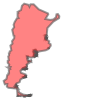

In [28]:
Argentina =  df_0[df_0['NAME_0'] == 'Argentina']['geometry'].iloc[0].simplify(tolerance=0.2)
Argentina

**Entre Ríos**

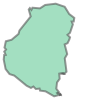

In [29]:
EntreRios = df[df['NAME_1'] == 'Entre Ríos']['geometry'].iloc[0].simplify(tolerance=0.05)
EntreRios

**Corrientes**

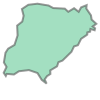

In [30]:
Corrientes = df[df['NAME_1'] == 'Corrientes']['geometry'].iloc[0].simplify(tolerance=0.05)
Corrientes

<a id='SOC_profile'></a>
#### **SOC Profile**
<a id='SOC_concentration_profile'></a>
#### SOC concentration

In [31]:
collection = ee.ImageCollection('users/iker/SOC_maps/SOC_concentration_q50')

concentration = ee.Image(collection.filterDate('2008-01-01', '2008-12-31').first())

# The data are SOC * 10 in order to use integers and therefore save space. 
# To obtain the real SOC values the data need to be divided by 10
concentration = concentration.divide(10)

<a id='SOC_concentration_profile_argentina'></a>
**Argentina**

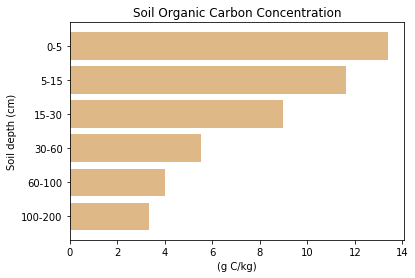

In [34]:
labels = ['0-5', '5-15', '15-30', '30-60', '60-100', '100-200']
values = soc_values(concentration, Argentina, SOC_type='concentration')

# Bar chart
bar_chart_hor(labels[::-1], values[::-1], 
              title='Soil Organic Carbon Concentration', 
              xlabel='(g C/kg)', ylabel='Soil depth (cm)',color='#DEB887')

<a id='SOC_concentration_profile_rios'></a>
**Entre Ríos**

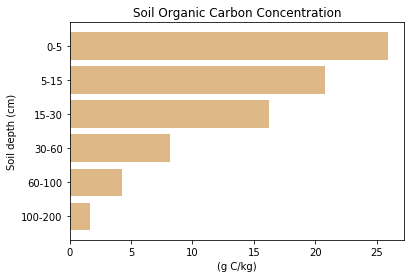

In [36]:
labels = ['0-5', '5-15', '15-30', '30-60', '60-100', '100-200']
values = soc_values(concentration, EntreRios, SOC_type='concentration')

# Bar chart
bar_chart_hor(labels[::-1], values[::-1], 
              title='Soil Organic Carbon Concentration', 
              xlabel='(g C/kg)', ylabel='Soil depth (cm)',color='#DEB887')

<a id='SOC_concentration_profile_compare'></a>
**Compare**

In [38]:
labels = ['0-5', '5-15', '15-30', '30-60', '60-100', '100-200'] 
categories = ['Argentina','Entre Ríos']
polygons = [Argentina, EntreRios]
values = []

for polygon in polygons:
    values.append(soc_values(concentration, polygon, SOC_type='concentration')[::-1])

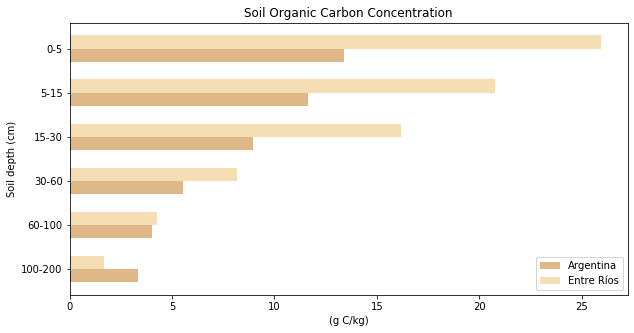

In [39]:
bar_chart_hor_multi(labels[::-1], values, categories, 
                    title='Soil Organic Carbon Concentration', 
                    xlabel='(g C/kg)', ylabel='Soil depth (cm)',
                    colors = ['#DEB887', '#F5DEB3'])

<a id='SOC_stock_profile'></a>
#### SOC stock

In [77]:
collection = ee.ImageCollection('users/iker/SOC_maps/SOC_stock_0_30')

stock = ee.Image(collection.filterDate('2008-01-01', '2008-12-31').first())

<a id='SOC_stock_profile_argentina'></a>
**Argentina**

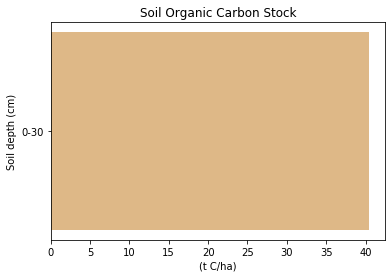

In [83]:
labels = ['0-30']
values = soc_values(stock, Argentina, SOC_type='stock')

# Bar chart
bar_chart_hor(labels[::-1], values[::-1], 
              title='Soil Organic Carbon Stock', 
              xlabel='(t C/ha)', ylabel='Soil depth (cm)',color='#DEB887')

<a id='SOC_stock_profile_rios'></a>
**Entre Ríos**

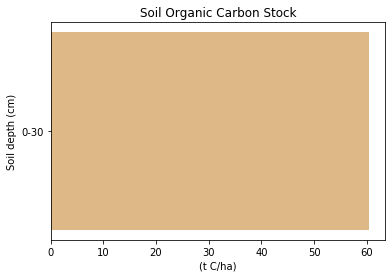

In [82]:
labels = ['0-30']
values = soc_values(stock, EntreRios, SOC_type='stock')

# Bar chart
bar_chart_hor(labels[::-1], values[::-1], 
              title='Soil Organic Carbon Stock', 
              xlabel='(t C/ha)', ylabel='Soil depth (cm)',color='#DEB887')

<a id='SOC_stock_profile_compare'></a>
**Compare**

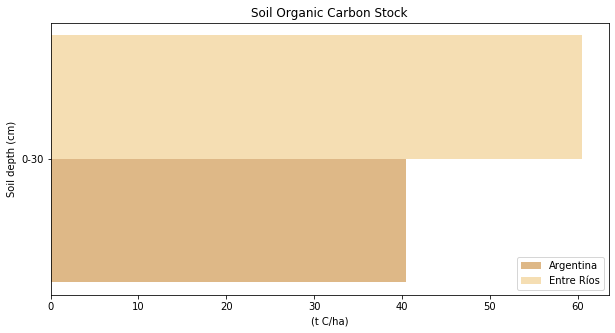

In [84]:
labels = ['0-30'] 
categories = ['Argentina','Entre Ríos']
polygons = [Argentina, EntreRios]
values = []

for polygon in polygons:
    values.append(soc_values(stock, polygon, SOC_type='stock')[::-1])
    
bar_chart_hor_multi(labels[::-1], values, categories, 
                    title='Soil Organic Carbon Stock', 
                    xlabel='(t C/ha)', ylabel='Soil depth (cm)',
                    colors = ['#DEB887', '#F5DEB3'])

***
<a id='SOC_time_series'></a>
#### **SOC Time series**
<a id='SOC_concentration_time'></a>
#### SOC concentration
<a id='SOC_concentration_time_argentina'></a>
**Argentina**

In [41]:
years = (np.arange(36)+1982).astype(np.str)

values = time_series(years, Argentina, SOC_type='concentration')

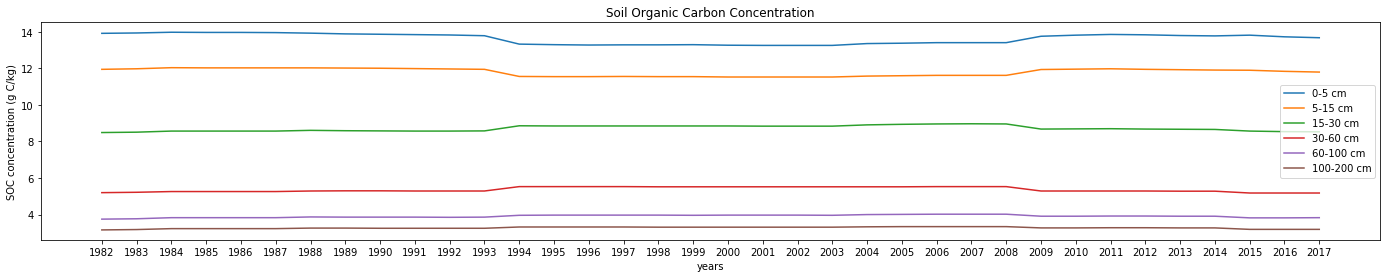

In [42]:
labels = ['0-5 cm', '5-15 cm', '15-30 cm', '30-60 cm', '60-100 cm', '100-200 cm'] 

line_chart_multi(years, values, title='Soil Organic Carbon Concentration', 
              xlabel='years', ylabel='SOC concentration (g C/kg)', labels=labels)

<a id='SOC_concentration_time_rios'></a>
**Entre Ríos**

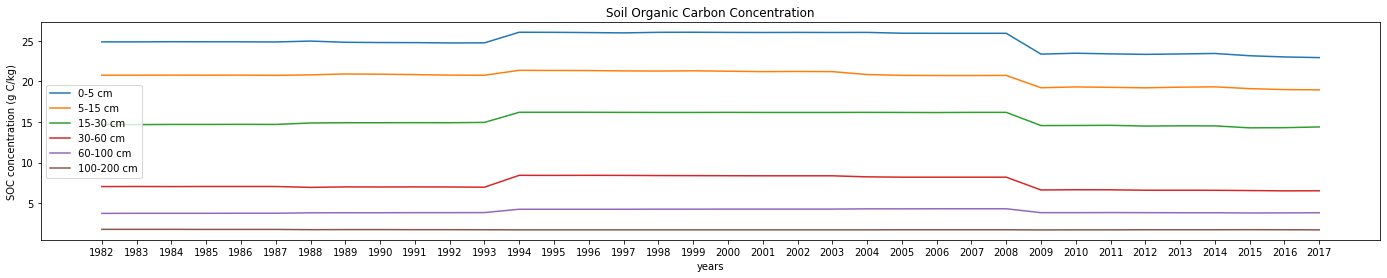

In [43]:
years = (np.arange(36)+1982).astype(np.str)

values = time_series(years, EntreRios, SOC_type='concentration')

labels = ['0-5 cm', '5-15 cm', '15-30 cm', '30-60 cm', '60-100 cm', '100-200 cm'] 

line_chart_multi(years, values, title='Soil Organic Carbon Concentration', 
              xlabel='years', ylabel='SOC concentration (g C/kg)', labels=labels)

<a id='SOC_stock_time'></a>
#### SOC stock
<a id='SOC_stock_time_argentina'></a>
**Argentina**

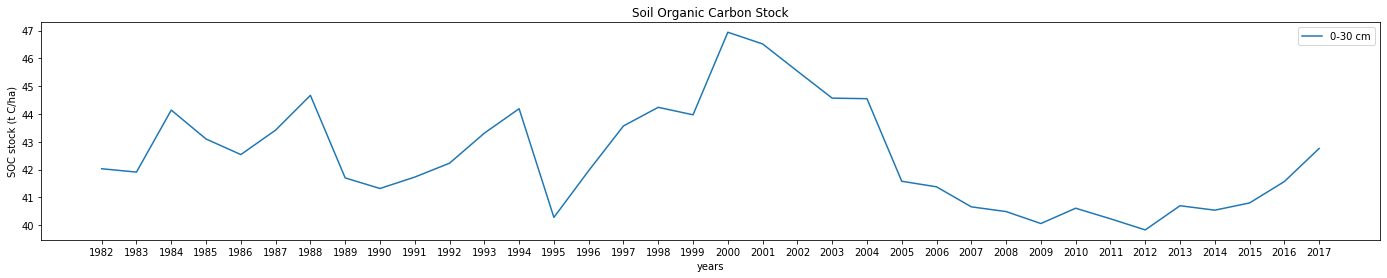

In [48]:
years = (np.arange(36)+1982).astype(np.str)

values = time_series(years, Argentina, SOC_type='stock')

labels = ['0-30 cm']

line_chart_multi(years, values, title='Soil Organic Carbon Stock', 
              xlabel='years', ylabel='SOC stock (t C/ha)', labels=labels)

<a id='SOC_stock_time_rios'></a>
**Entre Ríos**

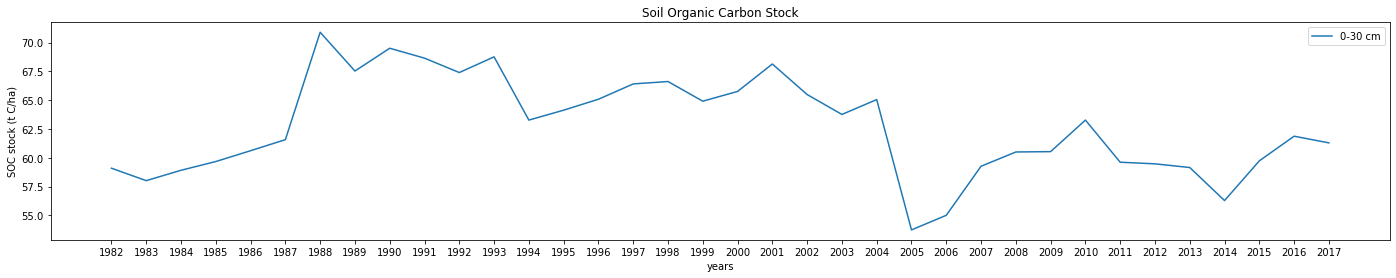

In [50]:
years = (np.arange(36)+1982).astype(np.str)

values = time_series(years, EntreRios, SOC_type='stock')

labels = ['0-30 cm']

line_chart_multi(years, values, title='Soil Organic Carbon Stock', 
              xlabel='years', ylabel='SOC stock (t C/ha)', labels=labels)

***
<a id='SOC_change'></a>
#### **SOC Change**
<a id='SOC_concentration_change'></a>
#### SOC concentration

In [51]:
collection = ee.ImageCollection('users/iker/SOC_maps/SOC_concentration_q50')

image1982 = ee.Image(collection.filterDate('1982-01-01', '1982-12-31').first())
image2017 = ee.Image(collection.filterDate('2017-01-01', '2017-12-31').first())

image1982 = ee.Image(collection.filterDate('1985-01-01', '1995-12-31').median())
image2017 = ee.Image(collection.filterDate('2005-01-01', '2015-12-31').median())

# The data are SOC * 10 in order to use integers and therefore save space. 
# To obtain the real SOC values the data need to be divided by 10
image1982 = image1982.divide(10)
image2017 = image2017.divide(10)

con_change = image2017.select('b1').subtract(image1982.select('b1'))

An image which is a composite or mosaic of input images with different projections will have the [default projection](https://developers.google.com/earth-engine/projections), which is WGS84 with 1-degree scale.
You can force operations to be performed in a specific projection with the `reproject()` method.

In [52]:
con_change_reproject = con_change.reproject('EPSG:4326', None, 250)

In [73]:
palette = "#B30200, #E34A33, #FC8D59, #FDCC8A, #FFFFCC, #A1DAB4, #31B3BD, #1C9099, #066C59"

map = display_results(con_change, palette = palette, min = -3, max = 3, geom = EntreRios)
map

In [56]:
# SOC concentration change
image = con_change_reproject
params = {'min': -6.9, 'max': 7.5, 'steps': 26, 'width': 0.3}

<a id='SOC_concentration_change_argentina'></a>
**Argentina**

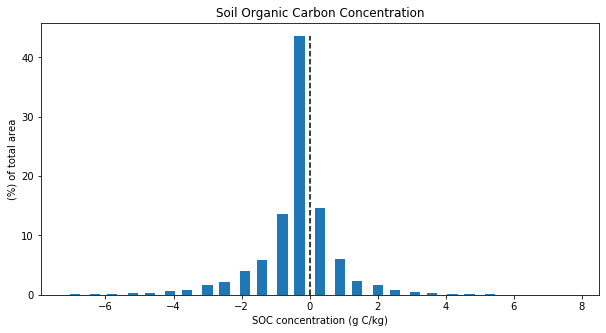

In [57]:
display_SOC_change(image, Argentina, params, title='Soil Organic Carbon Concentration', 
              xlabel='SOC concentration (g C/kg)', ylabel='(%) of total area')

<a id='SOC_concentration_change_rios'></a>
**Entre Ríos**

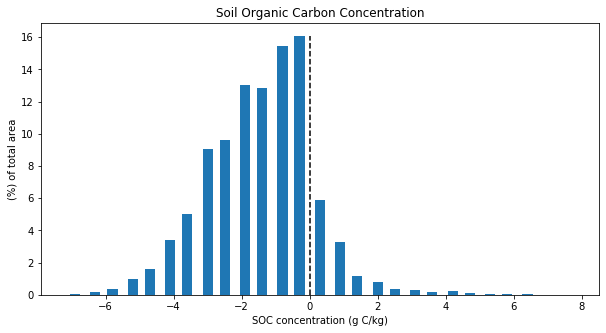

In [58]:
display_SOC_change(image, EntreRios, params, title='Soil Organic Carbon Concentration', 
              xlabel='SOC concentration (g C/kg)', ylabel='(%) of total area')

<a id='SOC_concentration_compare'></a>
**Compare**

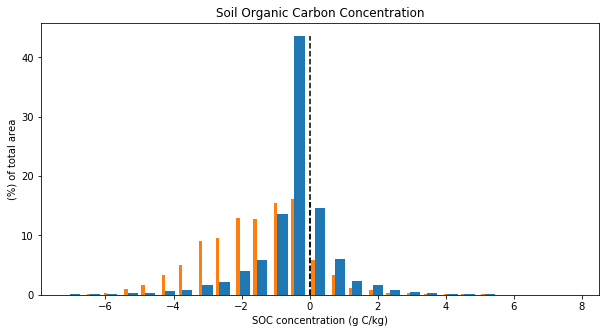

In [59]:
plt.figure(figsize=(10,5))
width = 0.3 
for i, polygon in enumerate([Argentina, EntreRios]):

    hist = ee_fixHist(image, polygon, params)

    array = np.around(np.array(hist[0].get('properties').get('histogram')), 1)
    x_min = array[:,0]
    count = array[:,1]
    
    per = count/count.sum()*100
    
    if i == 0:
        plt.bar(x_min, per, width=params['width'] )
        plt.xlim((params['min']-1, params['max']+1))
    else:
        plt.bar(x_min-0.2, per, width=0.1)
        
    plt.plot([0,0], [0,per.max()], color = 'k', linestyle = '--')
    
    plt.title('Soil Organic Carbon Concentration')
    plt.xlabel('SOC concentration (g C/kg)')
    plt.ylabel('(%) of total area')

**Dynamic sentences**

In [71]:
polygon = EntreRios

# SOC concentration change
params = {'min': -6.9, 'max': 7.5, 'steps': 26, 'width': 0.3}
bands = ['b1','b2','b3','b4','b5','b6']
labels = ['0-5', '5-15', '15-30', '30-60', '60-100', '100-200']

collection = ee.ImageCollection('users/iker/SOC_maps/SOC_concentration_q50')

image_from = ee.Image(collection.filterDate('1985-01-01', '1995-12-31').median())
image_to = ee.Image(collection.filterDate('2005-01-01', '2015-12-31').median())

# The data are SOC * 10 in order to use integers and therefore save space. 
# To obtain the real SOC values the data need to be divided by 10
image_from = image_from.divide(10)
image_to = image_to.divide(10)

for i, band in enumerate(bands):

    change = image_to.select(band).subtract(image_from.select(band))

    image = change.reproject('EPSG:4326', None, 250)
    
    hist = ee_fixHist(image, polygon, params)

    array = np.around(np.array(hist[0].get('properties').get('histogram')), 1)

    x_min = array[:,0]
    count = array[:,1]

    mean = sum(x_min*count)/sum(count)
    
    print('SOC concentration change averaging '+ str(np.around(mean, 2))+ ' g C/kg at ' + labels[i] + ' cm')

SOC concentration change averaging -1.47 g C/kg at 0-5 cm
SOC concentration change averaging -1.74 g C/kg at 5-15 cm
SOC concentration change averaging -0.56 g C/kg at 15-30 cm
SOC concentration change averaging -0.59 g C/kg at 30-60 cm
SOC concentration change averaging -0.26 g C/kg at 60-100 cm
SOC concentration change averaging -0.31 g C/kg at 100-200 cm


<a id='SOC_stock_change'></a>
#### SOC stock

In [60]:
collection = ee.ImageCollection('users/iker/SOC_maps/SOC_stock_0_30')

#image_from = ee.Image(collection.filterDate('1982-01-01', '1982-12-31').first())
#image_to = ee.Image(collection.filterDate('2017-01-01', '2017-12-31').first())

image_from = ee.Image(collection.filterDate('1985-01-01', '1995-12-31').median())
image_to = ee.Image(collection.filterDate('2005-01-01', '2015-12-31').median())

stock_change = image_to.select('b1').subtract(image_from.select('b1'))
stock_change_reproject = stock_change.reproject('EPSG:4326', None, 250)

In [74]:
palette = "#B30200, #E34A33, #FC8D59, #FDCC8A, #FFFFCC, #A1DAB4, #31B3BD, #1C9099, #066C59"

map = display_results(stock_change, palette = palette, min = -20, max = 20, geom = EntreRios)
map

In [63]:
# SOC concentration change
image = con_change_reproject
params = {'min': -6.9, 'max': 7.5, 'steps': 26, 'width': 0.3}

# SOC stock change
image = stock_change_reproject
params = {'min': -31.5, 'max': 30, 'steps': 26, 'width': 1.3}

<a id='SOC_stock_change_argentina'></a>
**Argentina**

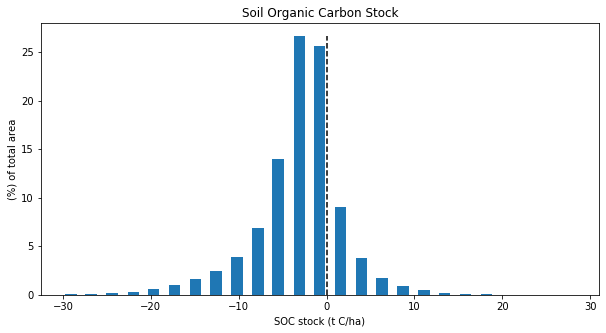

In [65]:
display_SOC_change(image, Argentina, params, title='Soil Organic Carbon Stock', 
              xlabel='SOC stock (t C/ha)', ylabel='(%) of total area')

<a id='SOC_stock_change_rios'></a>
**Entre Ríos**

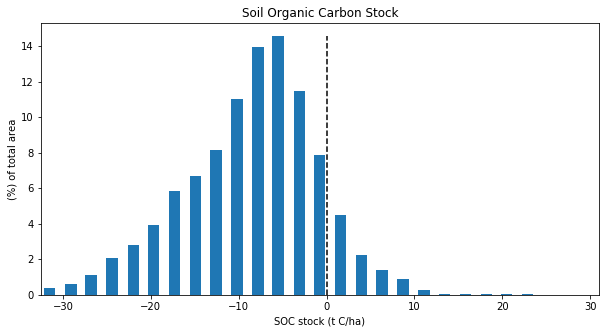

In [66]:
display_SOC_change(image, EntreRios, params, title='Soil Organic Carbon Stock', 
              xlabel='SOC stock (t C/ha)', ylabel='(%) of total area')

<a id='SOC_stock_change_compare'></a>
**Compare**

Text(0, 0.5, '(%) of total area')

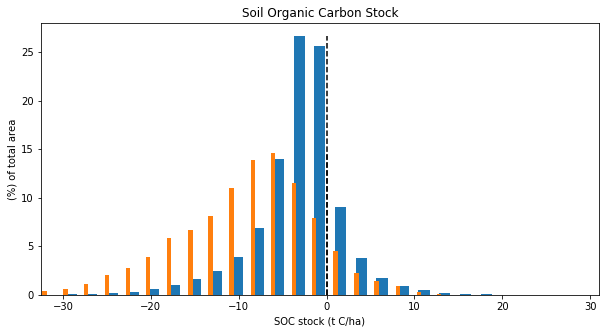

In [67]:
plt.figure(figsize=(10,5))
width = 0.3 
for i, polygon in enumerate([Argentina, EntreRios]):

    hist = ee_fixHist(image, polygon, params)

    array = np.around(np.array(hist[0].get('properties').get('histogram')), 1)
    x_min = array[:,0]
    count = array[:,1]
    
    per = count/count.sum()*100
    
    if i == 0:
        plt.bar(x_min, per, width=params['width'] )
        plt.xlim((params['min']-1, params['max']+1))
    else:
        plt.bar(x_min-0.6, per, width=0.5)
        
    plt.plot([0,0], [0,per.max()], color = 'k', linestyle = '--')
    
plt.title('Soil Organic Carbon Stock')
plt.xlabel('SOC stock (t C/ha)')
plt.ylabel('(%) of total area')

**Dynamic sentences**

In [68]:
polygon = EntreRios

# SOC stock change
image = stock_change_reproject
params = {'min': -31.5, 'max': 30, 'steps': 26, 'width': 1.3}

hist = ee_fixHist(image, polygon, params)

array = np.around(np.array(hist[0].get('properties').get('histogram')), 1)

x_min = array[:,0]
count = array[:,1]

mean = sum(x_min*count)/sum(count)

print('SOC stock change averaging '+ str(np.around(mean, 2))+ ' t C/ha at 0-30 cm')

SOC stock change averaging -8.58 t C/ha at 0-30 cm
